In [183]:
import sqlite3
import pandas as pd
from functions_sandbox import cleaner
import seaborn as sns
import matplotlib.pyplot as plt

location = r"D:\IT_projects\Turing_Colledge\Modul2\Sprint1\project\mental_health.sqlite"
con = sqlite3.connect(location)

Table No. 1

In [162]:
query1 = """
SELECT *
FROM Survey;
"""
pd.read_sql_query(query1, con)

,SurveyID,Description
0,2014,mental health survey for 2014
1,2016,mental health survey for 2016
2,2017,mental health survey for 2017
3,2018,mental health survey for 2018
4,2019,mental health survey for 2019


Table No. 2

In [163]:
query2 = """
SELECT *
FROM Question;
"""
pd.read_sql_query(query2, con)

,questiontext,questionid
0,What is your age?,1
1,What is your gender?,2
2,What country do you live in?,3
3,"If you live in the United States, which state ...",4
4,Are you self-employed?,5
...,...,...
100,Do you think that team members/co-workers woul...,114
101,"If yes, what condition(s) have you been diagno...",115
102,"If maybe, what condition(s) do you believe you...",116
103,Which of the following best describes your wor...,117


Table No. 3

In [164]:
query3 = """
SELECT *
FROM Answer;
"""
pd.read_sql_query(query3, con)

,AnswerText,SurveyID,UserID,QuestionID
0,37,2014,1,1
1,44,2014,2,1
2,32,2014,3,1
3,31,2014,4,1
4,31,2014,5,1
...,...,...,...,...
236893,Other,2016,2689,117
236894,Support,2016,2690,117
236895,Back-end Developer,2016,2691,117
236896,DevOps/SysAdmin,2016,2692,117


All tables joined

In [ ]:
query4 = """
SELECT Answer.AnswerText, Answer.SurveyID, Answer.UserID,
        Answer.QuestionID, Question.questiontext QuestionText,
        Survey.Description
FROM Answer
JOIN Question
ON Answer.QuestionID = Question.QuestionID
JOIN Survey
ON Answer.SurveyID = Survey.SurveyID
"""
pd.read_sql_query(query4, con)

## Data cleaning

In [155]:
joined_df = pd.read_sql_query(query4, con)
joined_df = cleaner(joined_df, info=False)
joined_df

,answertext,surveyid,userid,questionid,questiontext,description
0,37,2014,1,1,What is your age?,mental health survey for 2014
1,44,2014,2,1,What is your age?,mental health survey for 2014
2,32,2014,3,1,What is your age?,mental health survey for 2014
3,31,2014,4,1,What is your age?,mental health survey for 2014
4,31,2014,5,1,What is your age?,mental health survey for 2014
...,...,...,...,...,...,...
236893,Other,2016,2689,117,Which of the following best describes your wor...,mental health survey for 2016
236894,Support,2016,2690,117,Which of the following best describes your wor...,mental health survey for 2016
236895,Back-end Developer,2016,2691,117,Which of the following best describes your wor...,mental health survey for 2016
236896,DevOps/SysAdmin,2016,2692,117,Which of the following best describes your wor...,mental health survey for 2016


Check for the unique amount of numbers in questionid column.

In [ ]:
qid = len(joined_df["questionid"].unique()) #105 uniques
uid = len(joined_df["userid"].unique()) #4218 uniques
sid = len(joined_df["surveyid"].unique()) #5 uniques

After the given result 105, we must to check, which numbers  
of questions are excluded or deleted from table.

In [ ]:
expected_numbers = list(range(1, 118))
numbers = sorted(joined_df["questionid"].unique())
excluded_numbers = set(expected_numbers) - set(numbers)
print(f"Excluded numbers: {sorted(excluded_numbers)}",
      f"\nThere are {len(excluded_numbers)} excluded numbers")

With the simple calculation we find, that there are  
13 excluded numbers of questionid column in a joined table.

## EDA (Exploratory Data Analysis)

### Participants age analysis

Before analysing age, check of participants number  
has been performed

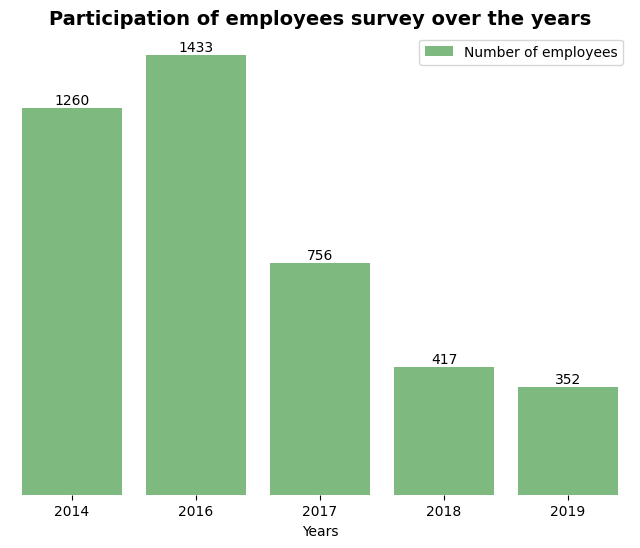

In [278]:
query = """
SELECT SurveyID Years, COUNT(DISTINCT(UserID)) Employees_No
FROM Answer
GROUP BY Years
ORDER BY Years;
"""
employees = pd.read_sql_query(query, con)
#SurveyID, Employees_No
plt.figure(figsize=(8, 6))

splot = sns.barplot(
    data=employees, 
    x="Years", 
    y="Employees_No", 
    label="Number of employees",
    color="#74c476",
    width=0.8
    )

for container in splot.containers:
    splot.bar_label(container)
splot.set_yticks([])
splot.set_ylabel(None)
splot.set_frame_on(False)
splot.set_title(
    "Participation of employees survey over the years",
    size=14,
    fontweight="bold",
    ha="center"
    )

plt.show()

It can be seen, that over the years, participation  
in surveys of employees tend to decreased starting with 2016.

Table with age, gender and years has been created  
where gender answers had to be fixed due to  
letter case sensitivity or unsatisfactory answer.

In [305]:
query = """
SELECT UserID, SurveyID Years,
MAX(CASE WHEN QuestionID = 1 THEN AnswerText END) AS Age,
MAX(CASE WHEN QuestionID = 2 THEN AnswerText END) AS Gender
FROM Answer
WHERE QuestionID IN (1, 2)
GROUP BY UserID
"""
genders_age = pd.read_sql_query(query, con)

genders_age["Gender"] = genders_age["Gender"].str.lower()
genders_age["Gender"] = genders_age["Gender"].apply(lambda x: "other" if x not in ("female", "male") else x)
genders_age = genders_age[genders_age["Gender"] != "other"]
genders_age["Age"] = genders_age["Age"].astype(int)

To show a difference between genders over the years, a barplot  
was created.

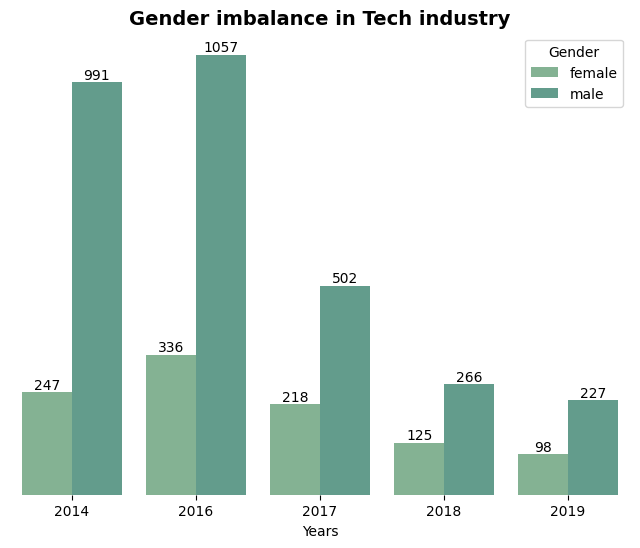

In [306]:
gender = genders_age.pivot_table(index="Years", columns="Gender", aggfunc="size")

plt.figure(figsize=(8, 6))
splot = sns.countplot(
    data=genders_age,
    x='Years',
    hue="Gender",
    width=0.8
)

for container in splot.containers:
    splot.bar_label(container)
splot.set_yticks([])
splot.set_ylabel(None)
splot.set_frame_on(False)
splot.set_title(
    "Gender imbalance in Tech industry",
    size=14,
    fontweight="bold",
    ha="center"
)

plt.show()

From the barplot a clear male trend in Tech industry  
could be seen. In each year at least half more males works in this area.  
However, huge split between male and female counts gets shorter starting  
with year 2017.

In table, anomalies for age values was checked and found  
some 0s, negative numbers, etc. All anomalies were filtered out  
and 18-100 age was left.  
Age was grouped to 7 groups: 10s, 20s, 30s... etc.

In [385]:
age_anomalies = genders_age[(genders_age["Age"] > 80) | (genders_age["Age"] < 18)]
age_filtered = genders_age.loc[(genders_age["Age"] > 18) & (genders_age["Age"] < 100)].copy()
# age_filtered
age_filtered.loc[:, "Age_group"] = 0
def agegroup(age):
    if 18 <= age < 20:
        return "10s"
    elif 20 <= age < 30:
        return "20s"
    elif 30 <= age < 40:
        return "30s"
    elif 40 <= age < 50:
        return "40s"
    elif 50 <= age < 60:
        return "50s"
    elif 60 <= age < 70:
        return "60s"
    elif 70 <= age < 80:
        return "70s"
    else:
        return "Unknown"

age_filtered.loc[:, "Age_group"] = age_filtered["Age"].apply(agegroup)
age_filtered = age_filtered.sort_values(by="Age_group")
print(age_filtered)
print(f"Overall mean age: {age_filtered['Age'].mean().astype(int)}")

      UserID  Years  Age  Gender Age_group
129      130   2014   19    male       10s
3514    3515   2018   19  female       10s
75        76   2014   19    male       10s
3481    3482   2018   19    male       10s
4083    4084   2019   19  female       10s
...      ...    ...  ...     ...       ...
2160    2161   2016   63    male       60s
560      561   2014   65    male       60s
2377    2378   2016   74  female       70s
2481    2482   2016   70    male       70s
1182    1183   2014   72  female       70s

[4050 rows x 5 columns]
Overall mean age: 33


To check which age groups were most and least active in  
survey, a line plot has been created.

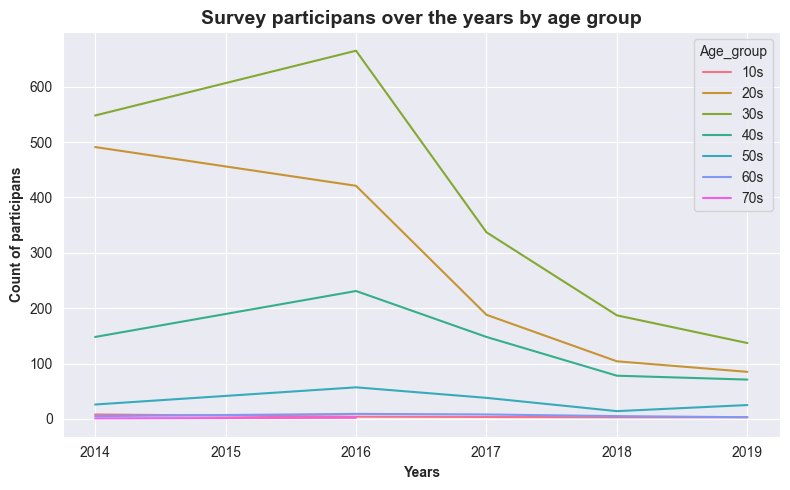

In [380]:
grouped_age = age_filtered.groupby(["Years", "Age_group"]).size().reset_index(name="Count").copy()

sns.set_style("darkgrid")
plt.figure(figsize=(8, 5))

splot = sns.lineplot(
    data=grouped_age,
    x="Years",
    y="Count",
    hue="Age_group"
)
splot.set_xlabel("Years", fontweight="bold")
splot.set_ylabel("Count of participans", fontweight="bold")
splot.set_title(
    "Survey participans over the years by age group", 
    size=14, fontweight="bold", 
    ha="center"
)
plt.tight_layout()

From this plot we can see, that over all years 30s group dominated  
following with 20s and 40s. It gives us a result that young to mid  
aged people tend to participate more in surveys but overall tendency  
shows lower interest each year.

A query was made with calculations to look a number of  
countries that participated in survey.

In [439]:
query = """
SELECT UserID, SurveyID Years, AnswerText Country
FROM Answer
WHERE QuestionID = 3
"""
countries = pd.read_sql_query(query, con)
countries["Country"] = countries["Country"].apply(lambda x: "United States" if x == "United States of America" else x)
print(f"Countries count: {len(countries['Country'].unique()) - 1}")
top5_countries = list(countries["Country"].value_counts().iloc[:5].index)
top5_df = countries[countries["Country"].isin(top5_countries)]
top5_df

Countries count: 79


,UserID,Years,Country
0,1,2014,United States
1,2,2014,United States
2,3,2014,Canada
3,4,2014,United Kingdom
4,5,2014,United States
...,...,...,...
4209,4210,2019,United States
4210,4211,2019,United States
4212,4213,2019,United States
4214,4215,2019,United States


Survey was placed on 79 countries.  
Top 5 countries were extracted (US, Canada, UK, Netherlands, Germany)  
for further investigation.

To look how participation of 5 countries changed over the  
years a countplot was made.

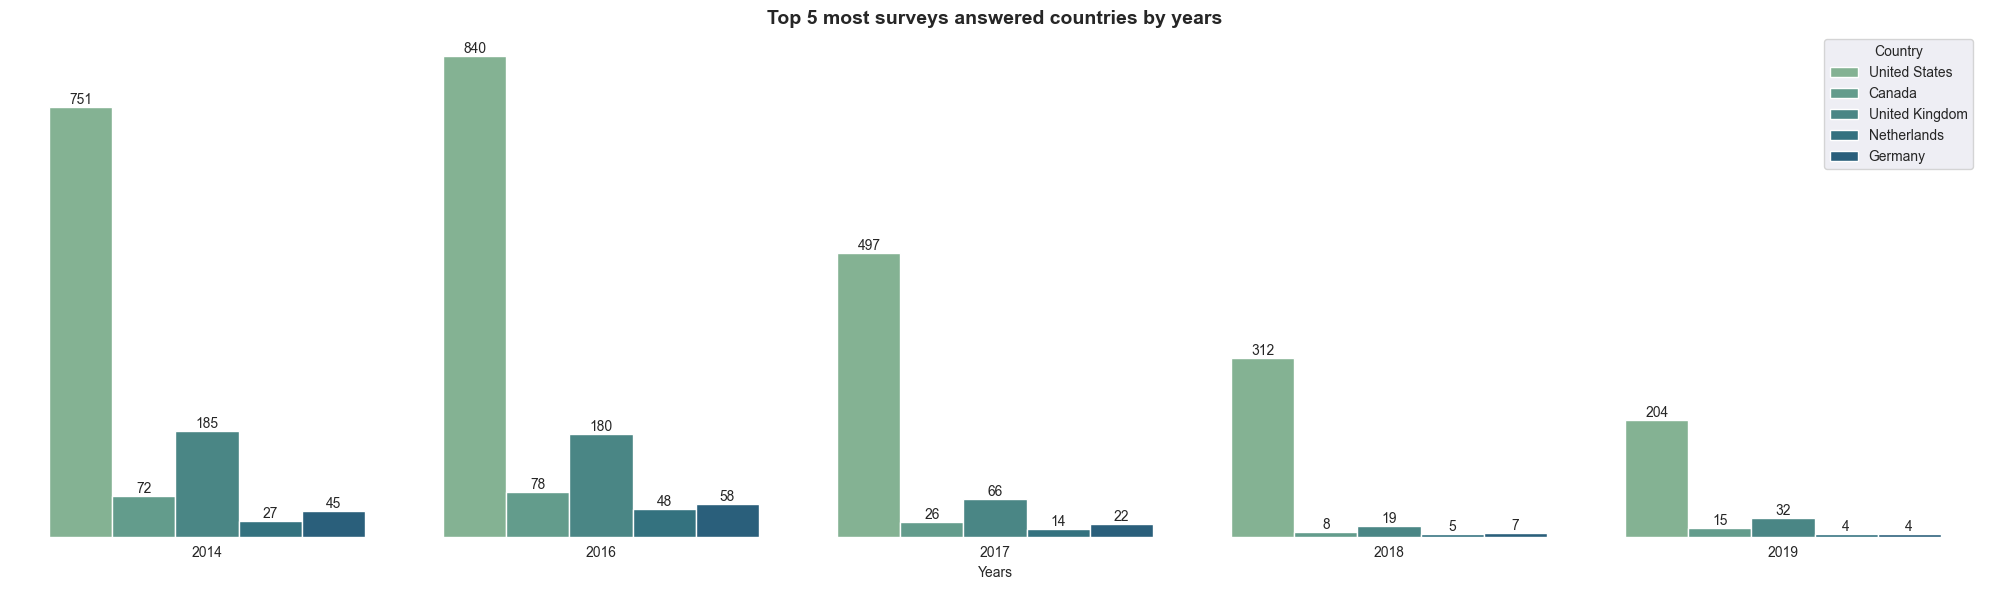

In [440]:
plt.figure(figsize=(20, 6))
splot = sns.countplot(
    data=top5_df,
    x="Years",
    hue="Country",
    width=0.8
)
for container in splot.containers:
    splot.bar_label(container)
splot.set_yticks([])
splot.set_ylabel(None)
splot.set_frame_on(False)
splot.set_title(
    "Top 5 most surveys answered countries by years",
    size=14,
    fontweight="bold",
    ha="center"
)
plt.tight_layout()
#pasitikrinti šalių amžiaus vidurkį ir pasižiūrėti ar nekoreliuoja su surveys

From this plot we can see, that US dominated over all the years.  
It could be due to various reasons, but further investigation  
is needed to explain the higher survey rate.

In [696]:
a = joined_df[joined_df["questiontext"] == ("Do you work remotely (outside of an office) at least 50% of the time?")]
# a["questionid"].unique()
a = joined_df[joined_df["questionid"] == 93]
a

,answertext,surveyid,userid,questionid,questiontext,description
18900,No,2014,1,93,Do you work remotely (outside of an office) at...,mental health survey for 2014
18901,No,2014,2,93,Do you work remotely (outside of an office) at...,mental health survey for 2014
18902,No,2014,3,93,Do you work remotely (outside of an office) at...,mental health survey for 2014
18903,No,2014,4,93,Do you work remotely (outside of an office) at...,mental health survey for 2014
18904,Yes,2014,5,93,Do you work remotely (outside of an office) at...,mental health survey for 2014
...,...,...,...,...,...,...
20155,Yes,2014,1256,93,Do you work remotely (outside of an office) at...,mental health survey for 2014
20156,No,2014,1257,93,Do you work remotely (outside of an office) at...,mental health survey for 2014
20157,Yes,2014,1258,93,Do you work remotely (outside of an office) at...,mental health survey for 2014
20158,No,2014,1259,93,Do you work remotely (outside of an office) at...,mental health survey for 2014


To answer the question of what percentage of people  
sought treatment for mental health issues over the years  
a special dataframe was made.

In [523]:
query = """
SELECT UserID, SurveyID Years, AnswerText Treatment
FROM Answer
WHERE QuestionID = 7
"""
treatment = pd.read_sql_query(query, con)
treatment_grouped = treatment.pivot_table(index="Years", columns="Treatment", aggfunc="size")
treatment_grouped.rename(columns={"0":"No", "1":"Yes"}, inplace=True)
treatment_grouped["Both"] = treatment_grouped["No"] + treatment_grouped["Yes"]
treatment_grouped["Seek_perc"] = round((treatment_grouped["Yes"]/(treatment_grouped["Both"])) * 100, 2)

To see view more clear, data was plotted.

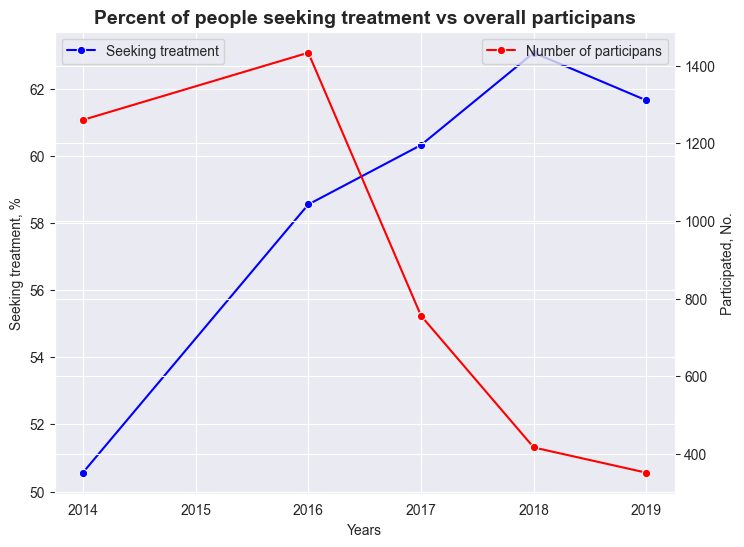

In [515]:
fig, ax1 = plt.subplots(figsize=(8, 6))
sns.lineplot(
    data=treatment_grouped,
    x="Years",
    y="Seek_perc",
    marker="o",
    color="blue",
    label="Seeking treatment",
    ax=ax1
)
ax2 = ax1.twinx()
sns.lineplot(
    data=treatment_grouped,
    x="Years",
    y="Both",
    marker="o",
    color="red",
    label="Number of participans",
    ax=ax2
)
ax1.set_ylabel("Seeking treatment, %")
ax2.set_ylabel("Participated, No.")
plt.title(
    "Percent of people seeking treatment vs overall participans",
    size=14,
    fontweight="bold",
    ha="center"
)

plt.show()

Blue line indicates the percentage of people that are seeking  
treatment for mental issues, while red line shows overall participans  
number and everything is showed with years included.  
We can observe that as the years go, people tend to seek treatment more  
despite survey taking participans decreasing.

In [610]:
age_treatment = pd.merge(treatment, age_filtered, on="UserID", how="inner")
age_treatment.drop(columns="Years_y", axis=1, inplace=True)
age_treatment.rename(columns={"Years_x":"Years"}, inplace=True)
# age_treatment = age_treatment[age_treatment["Treatment"] == "1"].copy()
age_treatment["Age_no"] = age_treatment["Age_group"].map(
    {"10s":10, "20s":20, "30s": 30, "40s":40, "50s":50, "60s":60, "70s":70})
a = age_treatment.groupby("Age_no")[["Treatment", "Gender"]].value_counts().unstack(fill_value=0)
a["summed"] = a["female"] + a["male"]
a.groupby("Age_no")[["summed", "female", "male"]].sum() #unclear for a moment

Gender,summed,female,male
Age_no,,,
10,18,5,13
20,1289,384,905
30,1874,422,1452
40,676,152,524
50,160,49,111
60,30,9,21
70,3,2,1


I wanted to look for what percentage of people seek for  
a health issues treatment in each age group. For that  
a pivot table and calculations were made.

In [624]:
age_seek = age_treatment.pivot_table(index="Age_group", columns="Treatment", aggfunc="size")
age_seek.rename(columns={"0":"No", "1":"Yes"}, inplace=True)
age_seek.fillna(0, inplace=True)
age_seek["Both"] = age_seek["No"] + age_seek["Yes"]
age_seek["Seek_perc"] = round(age_seek["Yes"] / age_seek["Both"] * 100, 2)
age_seek

Treatment,No,Yes,Both,Seek_perc
Age_group,,,,
10s,12.0,6.0,18.0,33.33
20s,610.0,679.0,1289.0,52.68
30s,811.0,1063.0,1874.0,56.72
40s,260.0,416.0,676.0,61.54
50s,60.0,100.0,160.0,62.50
60s,7.0,23.0,30.0,76.67
70s,0.0,3.0,3.0,100.00


In [ ]:
plt.figure(figsize=(8, 6))

splot = sns.barplot(
    data=age_seek, 
    x="Age_group", 
    y="Seek_perc", 
    label="Treatment seek percentage",
    color="#74c476",
    width=0.8
    )
for container in splot.containers:
    splot.bar_label(container)
splot.set_yticks([])
splot.set_ylabel(None)
splot.set_frame_on(False)

bplot = sns.lineplot(
    data=age_seek, 
    x="Age_group", 
    y="Both",
    ax=splot.twinx(),
    color="orange",
    marker="o",
    label="Overall participants"
)
bplot.set_ylabel("Overall participants")
bplot.grid(False)
splot.set_title(
    "Percentage of people who sought health issues treatment by age group",
    size=14,
    fontweight="bold",
    ha="center"
    )

plt.show()

It can be seen, that with older group follows higher treatment seek  
for menthal health issues. This could be explained younger age people usualy are more active and busy with many works, projects and doesn't spent that much time for therapists. On the other side, older people tend to take more time for mental health issues treatment.  
The bar jumps higher from 60s age group.

In [683]:
seek_gender = age_treatment.pivot_table(index="Gender", columns=["Treatment"], aggfunc="size")
seek_gender.rename(columns={"0":"No", "1":"Yes"}, inplace=True)
seek_gender["Both"] = seek_gender["No"] + seek_gender["Yes"]
seek_gender["Seek_perc"] = round(seek_gender["Yes"] / seek_gender["Both"] * 100, 2)
seek_gender.reset_index(inplace=True)
seek_gender

Treatment,Gender,No,Yes,Both,Seek_perc
0,female,277,746,1023,72.92
1,male,1483,1544,3027,51.01


Because of gender unequal number of survey we can see  
almost triple number of men (3027) participated in comparison to woman(1023).  
To dig deeper in answer above, overall percentage of people by gender which sought health  
issues treatment a barplot was used.

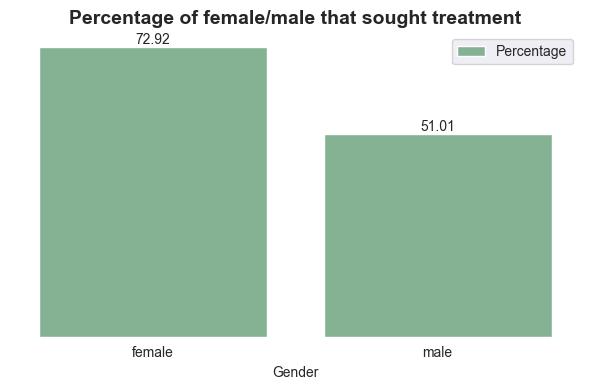

In [686]:
plt.figure(figsize=(6, 4))
splot = sns.barplot(
    data=seek_gender,
    x="Gender",
    y="Seek_perc",
    label="Percentage",
    width=0.8
)
for container in splot.containers:
    splot.bar_label(container)
splot.set_yticks([])
splot.set_ylabel(None)
splot.set_frame_on(False)
plt.title(
    "Percentage of female/male that sought treatment",
    size=14,
    fontweight="bold",
    ha="center"
)
plt.tight_layout()
plt.show()

We can see, that despite the higher number of men participated  
in survey, a higher percentage of female participates  
answered that they sought treatment for mental health issues.  
This could be explained that overall in principal woman are  
more caring and concerned about their and others health.  
Males should concern more.

I tried to look on how many participants in survey have  
or haven't been diagnosed with mental issues.

In [751]:
#33, 93
query = """ 
SELECT UserID, AnswerText Mental_dis
FROM Answer
WHERE QuestionID = 33
"""
mental = pd.read_sql_query(query, con)
print(f"Participants no: {mental['Mental_dis'].value_counts().sum()}")
mental = mental[mental["Mental_dis"].isin(["Yes", "No"])]
print(f"Participants with mental issues: {mental['Mental_dis'].value_counts().loc['Yes']}")
print(f"Participants without mental issues: {mental['Mental_dis'].value_counts().loc['No']}")

Participants no: 2958
Participants with mental disorder: 1237
Participants without mental disorder: 969


Despite there were 2958 participants, some of them weren't sure about  
the answer so only "Yes" and "No" was included in study. We have more  
people with (1237) mental issues than without (969).

Also, I looked at how many participants are self employed.

In [766]:
query = """ 
SELECT UserID, AnswerText Self_employed
FROM Answer
WHERE QuestionID = 5
"""
selfemp = pd.read_sql_query(query, con)
selfemp = selfemp[selfemp["Self_employed"].isin(["0", "1"])]
selfemp
print(f"Participants that work in companies: {selfemp['Self_employed'].value_counts().loc['0']}")
print(f"Participants that are self employed: {selfemp['Self_employed'].value_counts().loc['1']}")

Participants that work in companies: 3550
Participants that are self employed: 650


We can see that there are significantly more participants that  
work in companies than are self employed.

Finally I would like to see if there is a correlation between  
self employed participants and mental health issues. To do that,  
I need to merge two tables: mental and selfemp and clean it properly.  
0's represents "No" and 1's represents "Yes".

In [793]:
mental_remote = pd.merge(mental, selfemp, on="UserID", how="inner")
mental_remote["Mental_dis"] = mental_remote["Mental_dis"].replace({"No":0, "Yes":1})
mental_remote["Self_employed"] = mental_remote["Self_employed"].astype(int)
# mental_remote
ment_no = mental_remote[mental_remote["Mental_dis"] == 0]
ment_yes = mental_remote[mental_remote["Mental_dis"] == 1]

noself_nodis = ment_no["Self_employed"].value_counts()[0]
self_nodis = ment_no["Self_employed"].value_counts()[1]
noself_yesdis = ment_yes["Self_employed"].value_counts()[0]
self_yesdis = ment_yes["Self_employed"].value_counts()[1]

print(f"Company employed with no mental issues: {noself_nodis}")
print(f"Self employed with no mental issues: {self_nodis}")
print(f"Company employed with mental issues: {noself_yesdis}")
print(f"Self employed with mental issues: {self_yesdis}")

Self_employed
0    1024
1     213
Name: count, dtype: int64
Company employed with no mental issues: 813
Self employed with no mental issues: 156


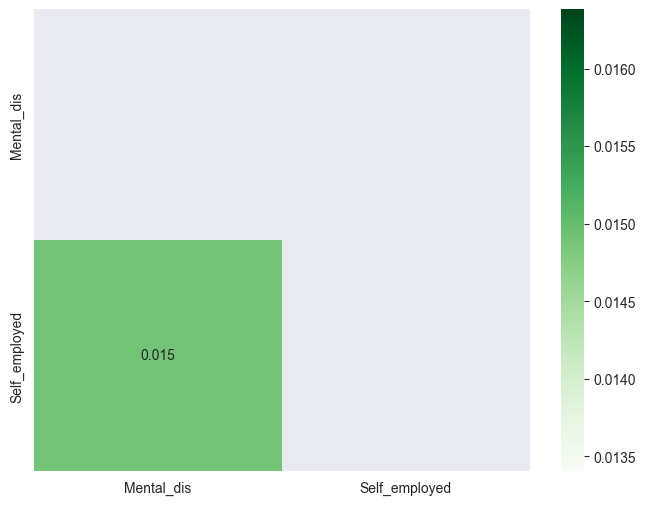